
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import os
from tqdm.notebook import tqdm
import skimage.io
from skimage.transform import resize

import torch
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt", sep='\t', skiprows=1) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_data, val_data, train_attrs, val_attrs = train_test_split(data, attrs, \
      train_size=0.9, shuffle=True)

train_data = torch.FloatTensor(train_data)
train_data = torch.permute(train_data, (0, 3, 1, 2))

val_data = torch.FloatTensor(val_data)
val_data = torch.permute(val_data, (0, 3, 1, 2))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, \
      drop_last=True, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

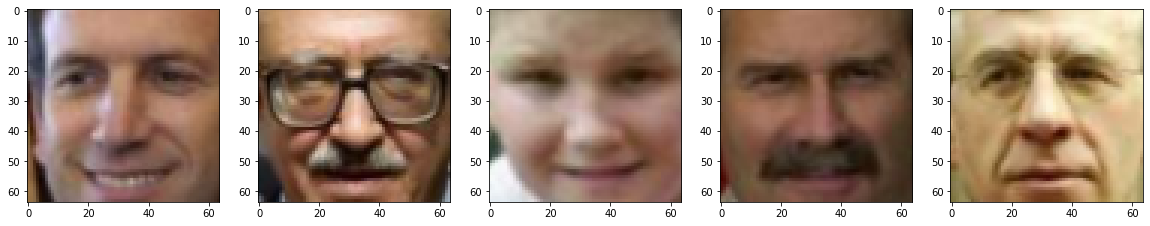

In [ ]:
plt.figure(figsize=(20, 6))
for i, img in enumerate(train_data[:5]):
  plt.subplot(1, 5, i+1)
  plt.imshow(img.permute(1,2,0))

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 32 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()

      self.encoder = nn.Sequential(
          # Conv layers
          nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(2, 2), # downsample: 64 -> 32
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.Dropout(0.1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2), # downsample: 32 -> 16
          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.Dropout(0.1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2), # downsample: 16 -> 8
          # Linear layers
          nn.Flatten(),
          nn.Linear(128*8*8, 512),
          nn.ReLU(),
          nn.Linear(512, dim_code)
      )
      self.decoder = nn.Sequential(
          # Linear layers
          nn.Linear(dim_code, 512),
          nn.ReLU(),
          nn.Linear(512, 128*8*8),
          nn.Unflatten(1, (128, 8, 8)),
          # Conv layers
          nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2, padding=0), # upsample: 8 -> 16
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0), # upsample: 16 -> 32
          nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0), # upsample: 32 -> 64
          nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
          nn.Sigmoid()
      )

    def forward(self, x):
      latent_code = self.encoder(x)
      reconst = self.decoder(latent_code)
      return reconst, latent_code

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
autoencoder = Autoencoder().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(autoencoder.parameters())

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
n_epochs = 20
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconst, _ = autoencoder(batch.to(device))
        loss = criterion(reconst, batch.to(device).float())
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          reconst, _ = autoencoder(batch.to(device))
          loss = criterion(reconst, batch.to(device).float())
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    print(f'Epoch: {epoch+1}, train_loss = {train_losses[-1]:.4f}, \
        val_loss = {val_losses[-1]:.4f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1, train_loss = 0.6220,         val_loss = 0.6136
Epoch: 2, train_loss = 0.6105,         val_loss = 0.6099
Epoch: 3, train_loss = 0.6081,         val_loss = 0.6075
Epoch: 4, train_loss = 0.6071,         val_loss = 0.6085
Epoch: 5, train_loss = 0.6064,         val_loss = 0.6079
Epoch: 6, train_loss = 0.6060,         val_loss = 0.6078
Epoch: 7, train_loss = 0.6057,         val_loss = 0.6066
Epoch: 8, train_loss = 0.6054,         val_loss = 0.6070
Epoch: 9, train_loss = 0.6053,         val_loss = 0.6070
Epoch: 10, train_loss = 0.6049,         val_loss = 0.6050
Epoch: 11, train_loss = 0.6048,         val_loss = 0.6070
Epoch: 12, train_loss = 0.6046,         val_loss = 0.6067


KeyboardInterrupt: ignored

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
      reconst, vector = autoencoder(batch.to(device))
      result_val = reconst.cpu().detach()
      latent_space_val = vector.cpu().detach()
      ground_truth_val = batch
      break

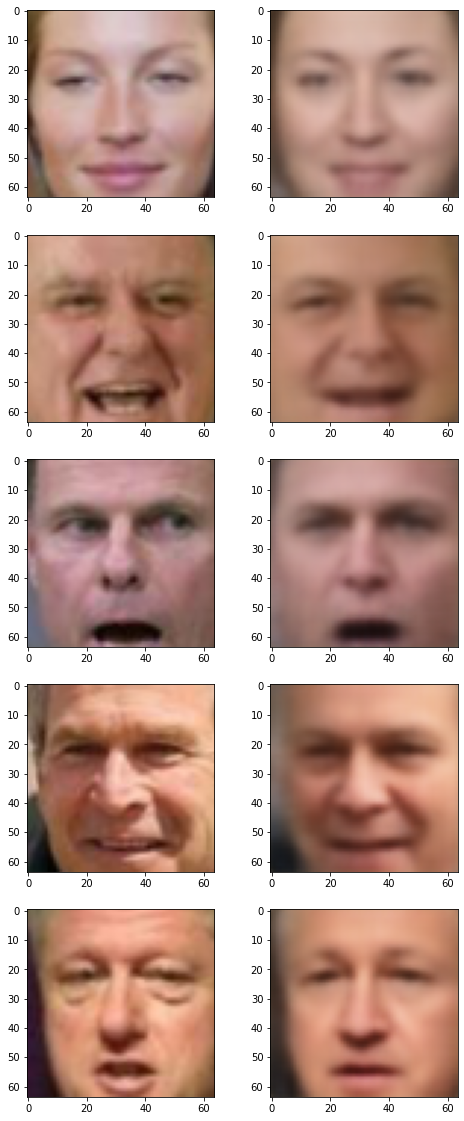

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth_val[:5], result_val[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt.permute(1,2,0))
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res.permute(1,2,0))

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# Посмотрим, как какие параметры распределения имеют векторы латентного пространства в батче из train:
autoencoder.eval()
with torch.no_grad():
    for batch in train_loader:
      _, vector = autoencoder(batch.to(device))
      latent_space_train = vector.cpu().detach()
      break

means = latent_space_train.mean(dim=0)
stds = latent_space_train.std(dim=0)

In [ ]:
output = autoencoder.decoder(latent_space_train.to(device)).cpu().detach()

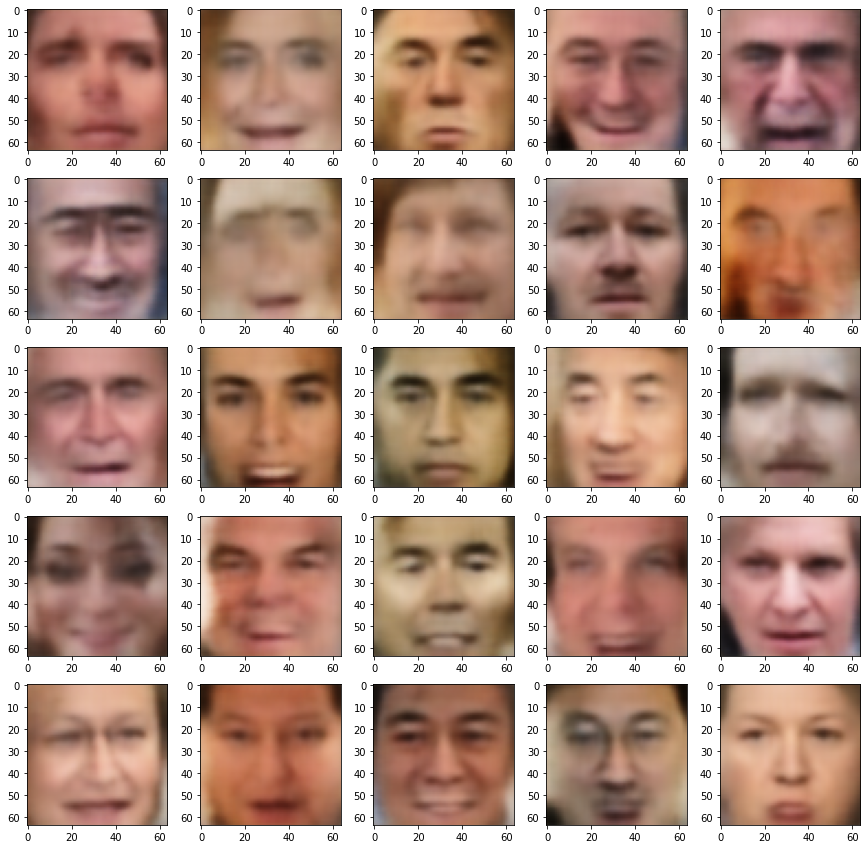

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.randn(25, dim_code)
# поправим среднее и разброс
z = z*stds + means

output = autoencoder.decoder(z.to(device)).cpu().detach()

# выведем полученные картинки
plt.figure(figsize=(15, 15))
for i, img in enumerate(output):
  plt.subplot(5, 5, i+1)
  plt.imshow(img.permute(1,2,0))

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Вектор улыбки смещается к женщинам, поэтому будем брать 15 женских и 15 мужских лиц 

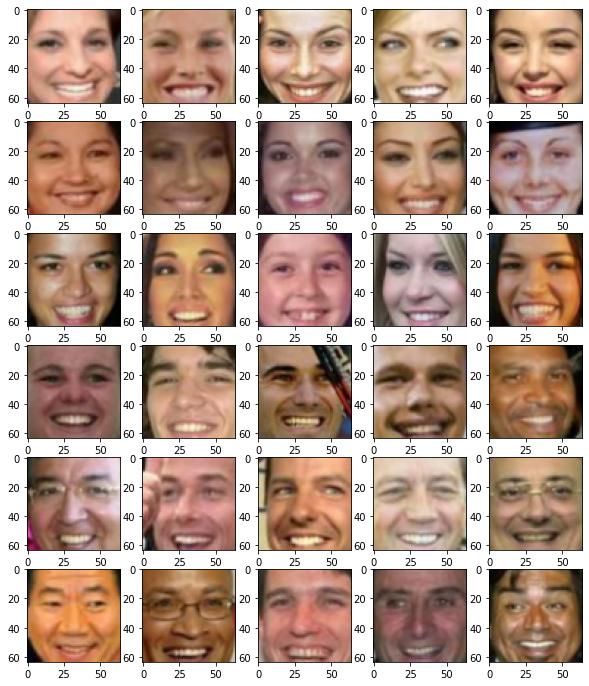

In [ ]:
# картинки из train_data с перепутанными индексами, а нужно сопоставлять индексы с таблицей
def get_train_idx(idx):
  """
  Переводит data.index to train.index
  """
  train_idx = np.where(train_attrs.index == idx)[0].item()
  return train_idx


# мужские улыбки
mask_male = train_attrs['Male'] > 0
data_smile_male = \
    train_attrs[mask_male].sort_values(by='Smiling', ascending=False)['Smiling'].head(15).index
smile_idx_male = [get_train_idx(idx) for idx in data_smile_male]
# женские улыбки
mask_female = train_attrs['Male'] < 0
data_smile_female = \
    train_attrs[mask_female].sort_values(by='Smiling', ascending=False)['Smiling'].head(15).index
smile_idx_female = [get_train_idx(idx) for idx in data_smile_female]
# 30 улыбок (всего)
smile_idx = np.concatenate((smile_idx_female, smile_idx_male))

# батч картинок с улыбками
smile_batch = torch.tensor([])
for i, idx in enumerate(smile_idx):
  if i==0:
    smile_batch = train_data[idx].unsqueeze(0) 
  else:
    smile_batch = torch.cat((smile_batch, train_data[idx].unsqueeze(0)))

# выведем картинки с улыбками
plt.figure(figsize=(10, 12))
for i in range(len(smile_batch)):
  plt.subplot(6, 5, i+1)
  plt.imshow(smile_batch[i].permute(1, 2, 0))

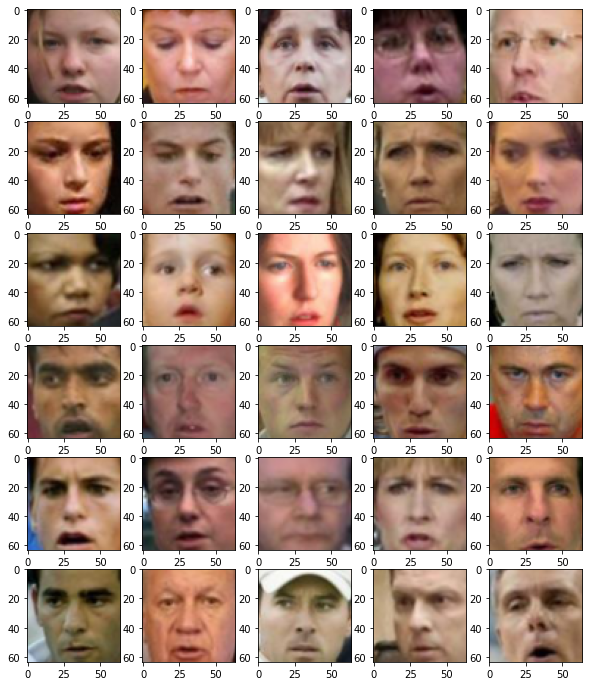

In [ ]:
# мужские грустные лица
mask_male = train_attrs['Male'] > 0
data_sad_male = \
    train_attrs[mask_male].sort_values(by='Smiling', ascending=True)['Smiling'].head(15).index
sad_idx_male = [get_train_idx(idx) for idx in data_sad_male]
# женские грустные лица
mask_female = train_attrs['Male'] < 0
data_sad_female = \
    train_attrs[mask_female].sort_values(by='Smiling', ascending=True)['Smiling'].head(15).index
sad_idx_female = [get_train_idx(idx) for idx in data_sad_female]
# 30 улыбок (всего)
sad_idx = np.concatenate((sad_idx_female, sad_idx_male))

# батч картинок без улыбок
sad_batch = torch.tensor([])
for i, idx in enumerate(sad_idx):
  if i==0:
    sad_batch = train_data[idx].unsqueeze(0) 
  else:
    sad_batch = torch.cat((sad_batch, train_data[idx].unsqueeze(0)))

# выведем картинки без улыбок
plt.figure(figsize=(10, 12))
for i in range(len(sad_batch)):
  plt.subplot(6, 5, i+1)
  plt.imshow(sad_batch[i].permute(1, 2, 0))

In [ ]:
# посчитаем вектор "улыбки"
autoencoder.eval()
with torch.no_grad():
  _, smile_latent = autoencoder(smile_batch.to(device))
  _, sad_latent = autoencoder(sad_batch.to(device))

smile_latent = smile_latent.cpu().detach().mean(dim=0)
sad_latent = sad_latent.cpu().detach().mean(dim=0)

smile_vector = smile_latent - sad_latent

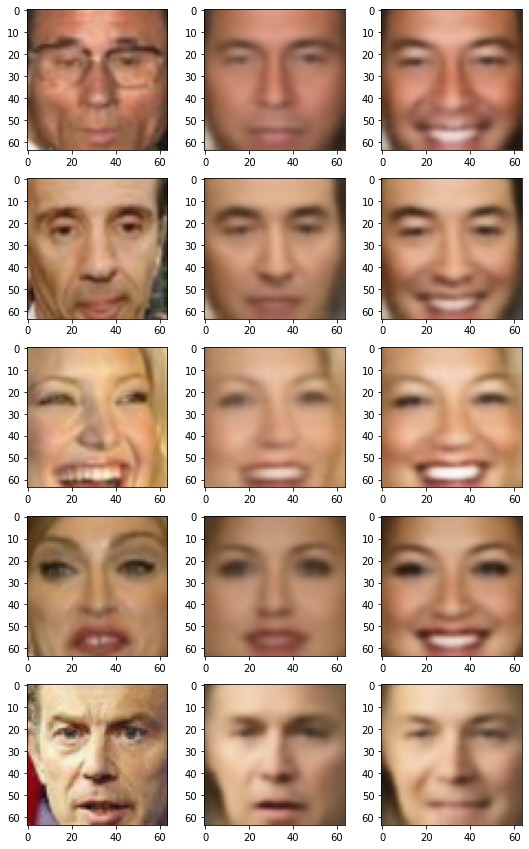

In [ ]:
# получим батч
autoencoder.eval()
with torch.no_grad():
    for batch in train_loader:
      reconst, vector = autoencoder(batch.to(device))
      result = reconst.cpu().detach()
      latent_space = vector.cpu().detach()
      ground_truth = batch
      break

# суммируем с "улыбкой"
latent_smile = latent_space + smile_vector
# прогоним через автоэнкодер
with torch.no_grad():
  result_smile = autoencoder.decoder(latent_smile.to(device)).cpu().detach()

# выведем картинки с улыбками
plt.figure(figsize=(9, 15))
for i, (gt, res, res_smile) in enumerate(zip(ground_truth[:5], result[:5], result_smile[:5])):
  plt.subplot(5, 3, 3*i+1)
  plt.imshow(gt.permute(1,2,0))
  plt.subplot(5, 3, 3*i+2)
  plt.imshow(res.permute(1,2,0))
  plt.subplot(5, 3, 3*i+3)
  plt.imshow(res_smile.permute(1,2,0))

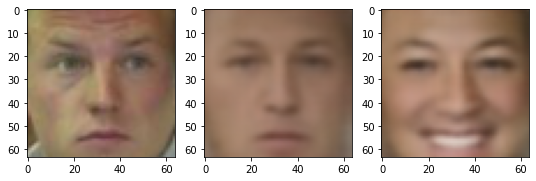

In [ ]:
# приделаем улыбку к неулыбчивому Кими Райконнену
def get_smily_img(img, smile=True):
  img = img.unsqueeze(0)
  with torch.no_grad():
    reconst, vector = autoencoder(img.to(device))
    result = reconst.cpu().detach()
    latent_space = vector.cpu().detach()
    if smile == True:
      latent_smile = latent_space + smile_vector
    else:
      latent_smile = latent_space - smile_vector
    result_smile = autoencoder.decoder(latent_smile.to(device)).cpu().detach()
  plt.figure(figsize=(9, 3))
  plt.subplot(1, 3, 1)
  plt.imshow(img[0].permute(1,2,0))
  plt.subplot(1, 3, 2)
  plt.imshow(result[0].permute(1,2,0))
  plt.subplot(1, 3, 3)
  plt.imshow(result_smile[0].permute(1,2,0))
  return


img = train_data[get_train_idx(7506)]
get_smily_img(img)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [2]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
val_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [9]:
dim_code = 32

class VAE(nn.Module):
    def __init__(self):
        # определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma
        super().__init__()
        self.encoder = nn.Sequential(
            # Conv layers
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # 28 -> 14
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14 -> 7
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2), # 7 -> 3
            nn.Flatten(),
            # Linear layers
            nn.Linear(256*3*3, 256),
            nn.ReLU(),
            nn.Linear(256, 2*dim_code)
        )
        
        self.decoder = nn.Sequential(
            # Linear layers
            nn.Linear(dim_code, 256),
            nn.ReLU(),
            nn.Linear(256, 256*3*3),
            nn.Unflatten(1, (256, 3, 3)),
            # Conv layers
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2, output_padding=1), # 3 -> 7
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2), # 7 -> 14
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2), # 14 -> 28
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma
            std = torch.exp(0.5 * logsigma) 
            eps = torch.randn_like(std) 
            sample = mu + (eps * std) 
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def forward(self, x):
        # используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction
        # return mu, logsigma, reconstruction
        x = self.encoder(x).view(-1, 2, dim_code)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        x = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decoder(x)
        return mu, logsigma, reconstruction

    def get_latent_vector(self, x):
        x = self.encoder(x).view(-1, 2, dim_code)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        latent = self.gaussian_sampler(mu, logsigma)
        return latent

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [10]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    # соедините тут две компоненты лосса. Mind the sign!
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [14]:
n_epochs = 10
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(batch[0].to(device))
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          mu, logsigma, reconstruction = autoencoder(batch[0].to(device))
          loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    print(f'Epoch: {epoch+1}, train_loss = {train_losses[-1]:.4f}, \
        val_loss = {val_losses[-1]:.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, train_loss = 4414.6227,         val_loss = 3568.3841
Epoch: 2, train_loss = 3595.0265,         val_loss = 3291.8597
Epoch: 3, train_loss = 3430.1775,         val_loss = 3189.7915
Epoch: 4, train_loss = 3352.5055,         val_loss = 3142.8298
Epoch: 5, train_loss = 3291.9102,         val_loss = 3084.2496
Epoch: 6, train_loss = 3252.2930,         val_loss = 3081.8792
Epoch: 7, train_loss = 3225.6097,         val_loss = 3009.4351
Epoch: 8, train_loss = 3202.1801,         val_loss = 3029.8317
Epoch: 9, train_loss = 3183.4986,         val_loss = 2989.2993
Epoch: 10, train_loss = 3169.0488,         val_loss = 3030.3584


In [32]:
torch.save(autoencoder.state_dict(), 'autoencoder_mnist.pt')

In [40]:
# autoencoder = VAE().to(device)
# autoencoder.load_state_dict(torch.load('autoencoder_mnist.pt'))
# autoencoder.eval()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [41]:
autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
      _, _, reconst = autoencoder(batch[0].to(device))
      reconst = reconst.cpu().detach()
      ground_truth = batch[0]
      break

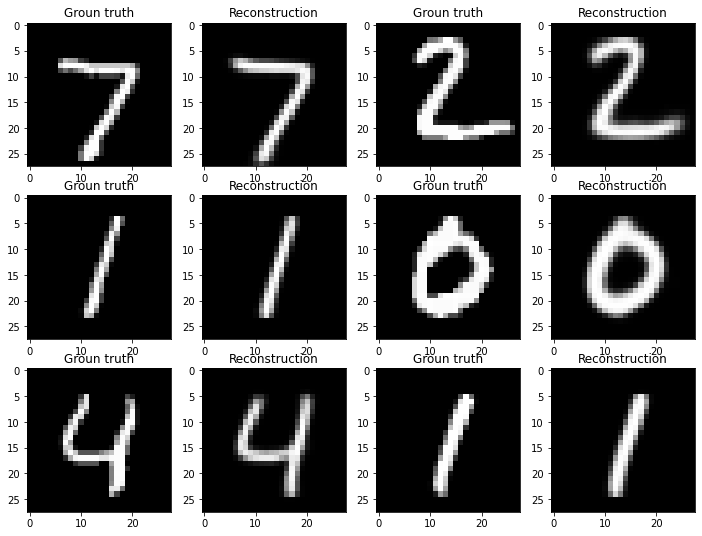

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
for i, (gt, rec) in enumerate(zip(ground_truth[:6], reconst[:6])):
  plt.subplot(3, 4, 2*i+1)
  plt.title('Groun truth')
  plt.imshow(gt[0], cmap='gray')
  plt.subplot(3, 4, 2*i+2)
  plt.title('Reconstruction')
  plt.imshow(rec[0], cmap='gray')

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [52]:
# посчитаем на train-батче latent_mu и latent_std
autoencoder.eval()
with torch.no_grad():
    for batch in train_loader:
      latent_mu, latent_logsigma, _ = autoencoder(batch[0].to(device))
      latent_mu = latent_mu.cpu().detach()
      latent_logsigma = latent_logsigma.cpu().detach()
      break

latent_std = torch.exp(0.5 * latent_logsigma) 

means = latent_mu.mean(dim=0)
stds = latent_std.mean(dim=0)

# выведем mean и std, чтобы убедиться, что loss правильно работает (mean~0, std~1)
print(means)
print(stds)

tensor([ 0.0680, -0.0457, -0.0049, -0.0010,  0.1680, -0.1395,  0.0470, -0.2695,
         0.1228,  0.0327,  0.0402,  0.0689, -0.0100, -0.0319,  0.0275,  0.0112,
        -0.0666,  0.0256, -0.1789, -0.0626,  0.0045,  0.0400,  0.0404, -0.0634,
         0.0661,  0.1029, -0.0149,  0.0348, -0.0826,  0.0726, -0.0308, -0.0522])
tensor([0.9851, 0.9949, 0.9735, 1.0123, 0.0879, 0.1488, 1.0050, 0.2945, 0.9696,
        0.9440, 0.1423, 0.0737, 0.9888, 0.9561, 0.9979, 0.9945, 0.9958, 1.0045,
        0.1706, 1.0110, 0.9912, 0.9889, 1.0234, 0.3537, 0.9680, 0.1199, 0.9940,
        0.9512, 0.2199, 0.9782, 1.0009, 0.1629])


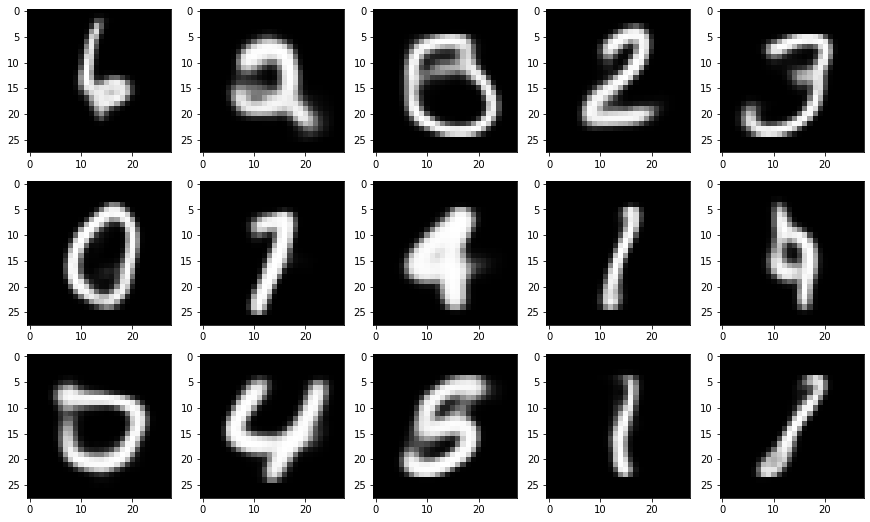

In [81]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = torch.FloatTensor(np.array([np.random.normal(0, 1, dim_code) for i in range(15)]))
# поправку с stds и means я не добавляю, потому что 
# 1) means~0, stds~1
# 2) выводятся одни восьмерки

# скормим z декодеру
autoencoder.eval()
with torch.no_grad():
  output = autoencoder.decoder(z.to(device)).cpu().detach()

# выведем полученные картинки
plt.figure(figsize=(15, 9))
for i, img in enumerate(output):
  plt.subplot(3, 5, i+1)
  plt.imshow(img[0], cmap='gray')

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном пространстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

Пространство латентных векторов, размерность: (10000, 32)
Пространство векторов после TSNE, размерность: (10000, 2)


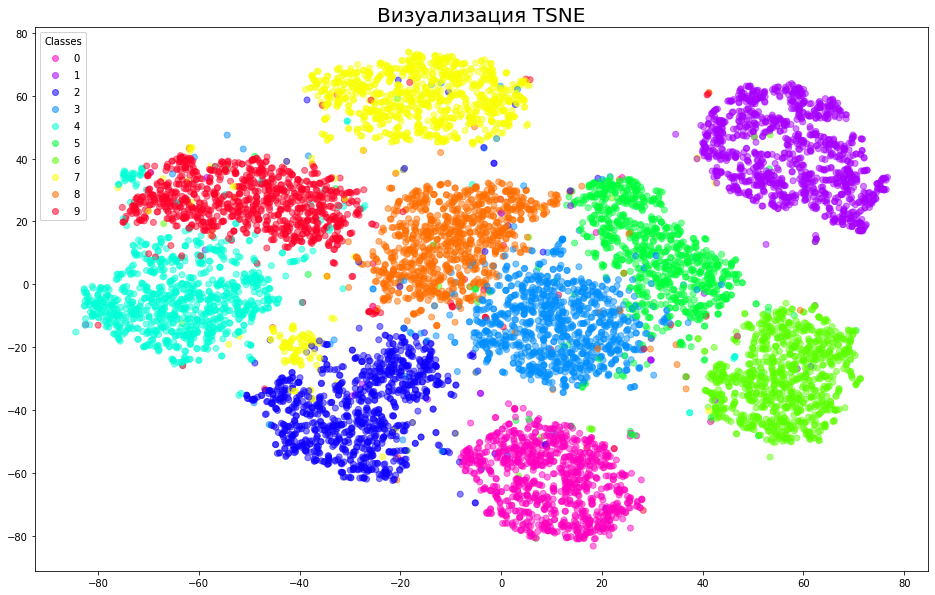

In [178]:
# лейблы цифр из val_dataset
labels = []
for data in val_dataset:
  labels.append(data[1])

# получение латентных представлений
autoencoder.eval()
latent_space = torch.tensor([])
with torch.no_grad():
    for i, batch in enumerate(val_loader):
      latent_mu, _ , _ = autoencoder(batch[0].to(device))
      latent_mu = latent_mu.cpu().detach()
      if i==0:
        latent_space = latent_mu
      else:
        latent_space = torch.cat((latent_space, latent_mu))   

latent_space = latent_space.numpy()
print(f'Пространство латентных векторов, размерность: {latent_space.shape}')

# применения TSNE 
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
space = tsne.fit_transform(latent_space)
print(f'Пространство векторов после TSNE, размерность: {space.shape}')

# визуализация
fig, ax = plt.subplots(figsize=(16,10))
scatter = ax.scatter(x=space[:,0], y=space[:, 1], c=labels, cmap='gist_rainbow_r', alpha=0.5)
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
plt.title('Визуализация TSNE', fontsize=20);

Что вы думаете о виде латентного представления?

#### Вывод: 
Цифры после применения TSNE на визуализации группируются в 10 различимых облаков, из чего мы делаем вывод, что encoder справился с задачей, и классы чисел различимы

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [7]:
dim_code = 32
num_classes = 10

class CVAE(nn.Module):
    def __init__(self):
        # определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma
           
        # Encoder's conv layers
        super().__init__()

        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # 28 -> 14
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14 -> 7
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(), # -> 128*7*7
        )
        # Encoder's linear layers
        self.enc_linear = nn.Sequential(
            nn.Linear(128*7*7 + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2*dim_code)
        )
        # Decoder's linear layers
        self.dec_linear = nn.Sequential(
            nn.Linear(dim_code + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 128*7*7),
            nn.Unflatten(1, (128, 7, 7))
        )
        # Decoder's conv layers
        self.dec_conv = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2), # 7 -> 14
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2), # 14 -> 28
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def class2onehot(self, class_num):
      """
      Перевочид цифру 0...9 в ее one_hot представление
      """
      num_onehot = torch.zeros(len(class_num), num_classes).float()
      for i, num in enumerate(class_num):
        num_onehot[i, num] = 1
      return num_onehot.to(device)

    def encode(self, x, class_num):
        # реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки
        x = self.enc_conv(x)
        num_onehot = self.class2onehot(class_num)
        x = torch.concat((x, num_onehot), dim=1)
        x = self.enc_linear(x)
        x = x.view(-1, 2, dim_code)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        
        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) 
            eps = torch.randn_like(std) 
            sample = mu + (eps * std) 
            return sample
        else:
            return mu
    
    def decode(self, z, class_num):
        # реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction
        num_onehot = self.class2onehot(class_num)
        z = torch.concat((z, num_onehot), dim=1)
        z = self.dec_linear(z)
        reconstruction = self.dec_conv(z)
        return reconstruction

    def forward(self, x, class_num):
        # используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [8]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
conditional_vae = CVAE().to(device)
criterion = loss_vae
optimizer = torch.optim.Adam(conditional_vae.parameters())

In [10]:
n_epochs = 15
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    conditional_vae.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = conditional_vae(batch[0].to(device), batch[1].to(device))
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    conditional_vae.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          mu, logsigma, reconstruction = conditional_vae(batch[0].to(device), batch[1].to(device))
          loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    print(f'Epoch: {epoch+1}, train_loss = {train_losses[-1]:.4f}, \
        val_loss = {val_losses[-1]:.4f}')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1, train_loss = 4528.4822,         val_loss = 3706.3868
Epoch: 2, train_loss = 3644.0469,         val_loss = 3390.8893
Epoch: 3, train_loss = 3492.1314,         val_loss = 3303.8879
Epoch: 4, train_loss = 3428.1819,         val_loss = 3246.3239
Epoch: 5, train_loss = 3386.9596,         val_loss = 3242.5543
Epoch: 6, train_loss = 3351.6400,         val_loss = 3228.2773
Epoch: 7, train_loss = 3324.5590,         val_loss = 3203.4284
Epoch: 8, train_loss = 3302.9421,         val_loss = 3178.2821
Epoch: 9, train_loss = 3281.8740,         val_loss = 3172.9411
Epoch: 10, train_loss = 3266.3899,         val_loss = 3158.5104
Epoch: 11, train_loss = 3249.5014,         val_loss = 3154.1622
Epoch: 12, train_loss = 3234.4116,         val_loss = 3135.5318
Epoch: 13, train_loss = 3223.3236,         val_loss = 3126.6451
Epoch: 14, train_loss = 3209.3275,         val_loss = 3116.2290
Epoch: 15, train_loss = 3200.8413,         val_loss = 3120.4563


In [11]:
torch.save(conditional_vae.state_dict(), 'cvae_mnist.pt')

In [ ]:
# conditional_vae = CVAE().to(device)
# conditional_vae.load_state_dict(torch.load('cvae_mnist.pt'))
# conditional_vae.eval()

Проверим восстановление картинок

In [12]:
conditional_vae.eval()
with torch.no_grad():
    for batch in val_loader:
      _, _, reconst = conditional_vae(batch[0].to(device), batch[1].to(device))
      reconst = reconst.cpu().detach()
      ground_truth = batch[0]
      break

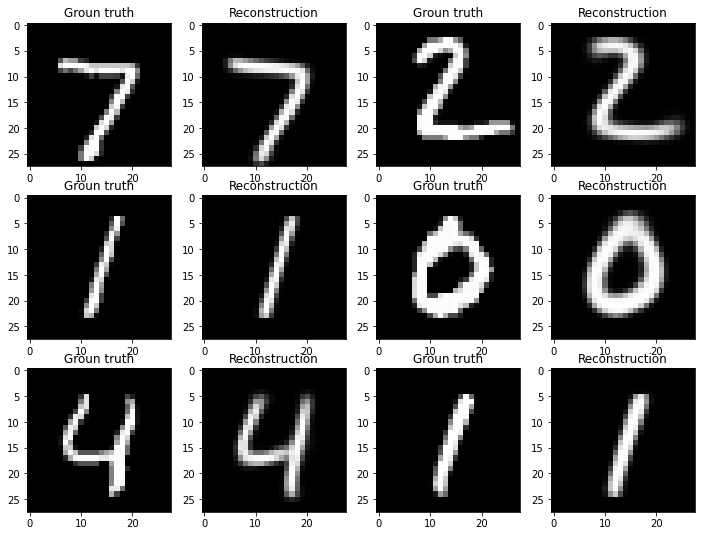

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
for i, (gt, rec) in enumerate(zip(ground_truth[:6], reconst[:6])):
  plt.subplot(3, 4, 2*i+1)
  plt.title('Groun truth')
  plt.imshow(gt[0], cmap='gray')
  plt.subplot(3, 4, 2*i+2)
  plt.title('Reconstruction')
  plt.imshow(rec[0], cmap='gray')

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [95]:
# посчитаем на train-е means и stds
conditional_vae.eval()
means = torch.Tensor([])
stds = torch.Tensor([])
with torch.no_grad():
    for i, batch in enumerate(train_loader):
      latent_mu, latent_logsigma, _ = conditional_vae(batch[0].to(device), batch[1].to(device))
      latent_mu = latent_mu.cpu().detach()
      latent_logsigma = latent_logsigma.cpu().detach()
      latent_std = torch.exp(0.5 * latent_logsigma) 
      if i==0:
        means = latent_mu
        stds = latent_std
      else:
        means = torch.cat((means, latent_mu))
        stds = torch.cat((stds, latent_std))

means = means.mean(dim=0)
stds = stds.mean(dim=0)
print(f'Means:\n {means}')
print(f'Stds:\n {stds}')

# таблица с числами
numbers = torch.arange(10).repeat(5, 1).T

Means:
 tensor([-0.0254, -0.0025, -0.0137,  0.0033, -0.0107,  0.0178,  0.0419, -0.0169,
         0.0120,  0.0027,  0.0086,  0.0373,  0.0128, -0.0265, -0.0145,  0.0199,
         0.0306,  0.0237, -0.0306, -0.0245, -0.0035, -0.0131,  0.0083, -0.0037,
         0.0034, -0.0276, -0.0098, -0.0530,  0.0256,  0.0126, -0.0464,  0.0086])
Stds:
 tensor([0.9888, 0.9880, 1.0051, 1.0130, 0.9922, 1.0070, 0.9819, 0.0818, 0.1592,
        1.0044, 1.0108, 0.9842, 0.9864, 0.9753, 0.9914, 0.9679, 0.1020, 0.9961,
        0.9734, 0.9770, 0.1594, 0.9880, 0.9518, 0.9905, 0.9948, 0.1777, 0.9903,
        0.9625, 0.9828, 0.9642, 0.1891, 0.9952])


In [98]:
print(numbers)

tensor([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8],
        [9, 9, 9, 9, 9]])


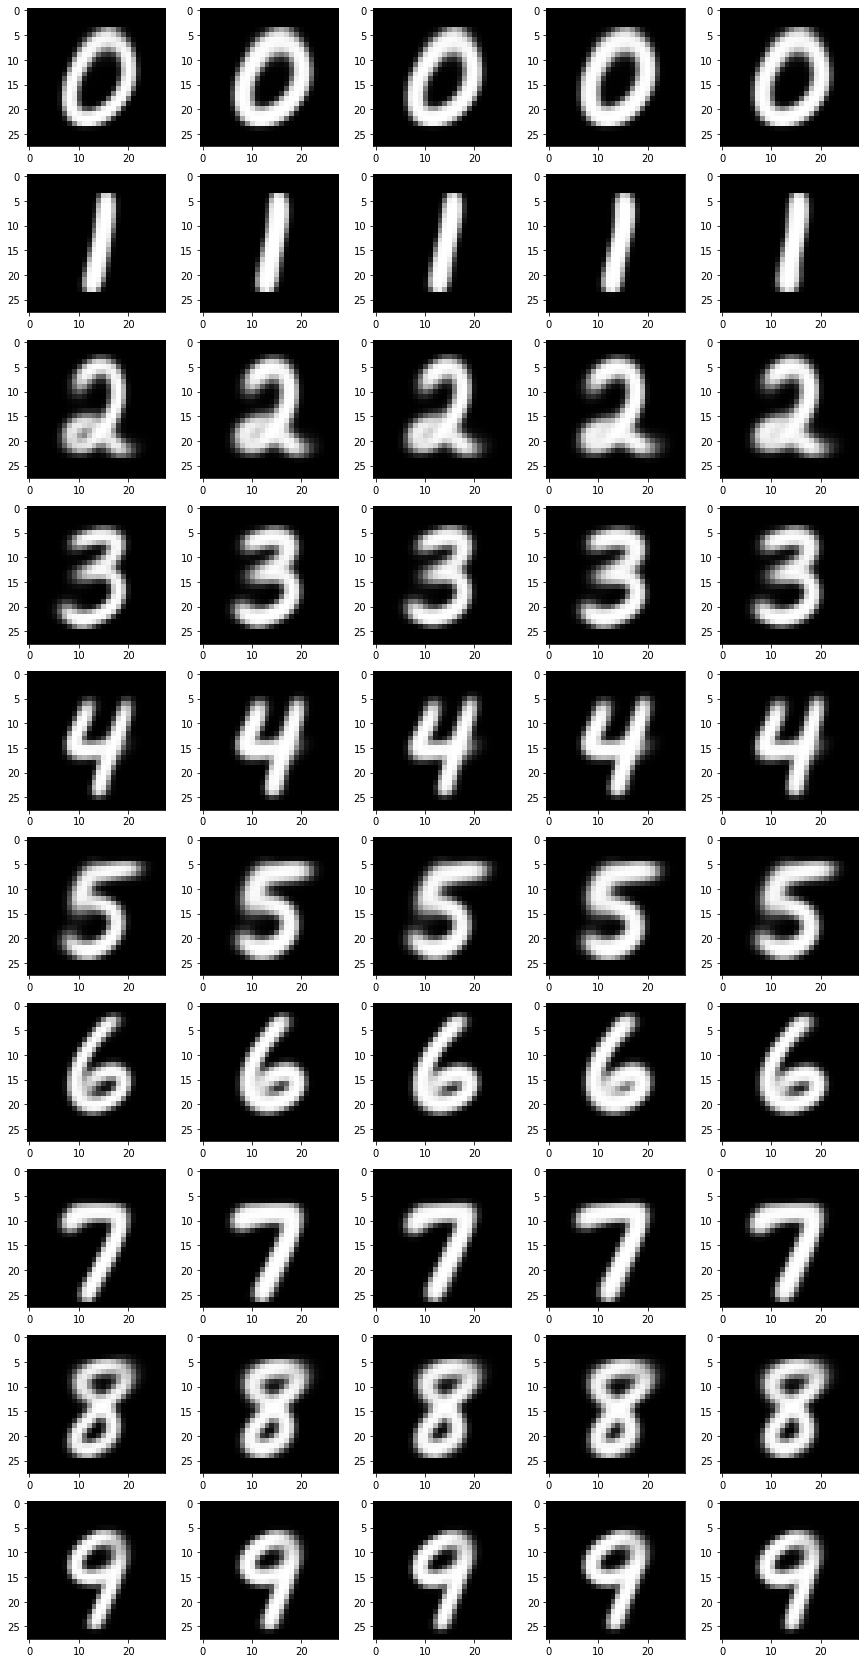

In [96]:
# c поправкой на means и stds
z = torch.FloatTensor(np.array([np.random.normal(0, 1, dim_code) for i in range(5)]))
z = z*stds + means

# скормим z декодеру
conditional_vae.eval()
result = []
with torch.no_grad():
  for i in range(10):
    output = conditional_vae.decode(z.to(device), numbers[i].to(device)).cpu().detach()
    result.append(output)

# выведем полученные картинки
plt.figure(figsize=(15, 30))
for i, imgs in enumerate(result):
  for j, img in enumerate(imgs):
    plt.subplot(10, 5, 5*i+j+1)
    plt.imshow(img[0], cmap='gray')

С поправкой means и stds цифры хорошо генерятся, но выходят слишком одинаковыми (!но они разные! видно, что двойки разные, и четверки тоже)

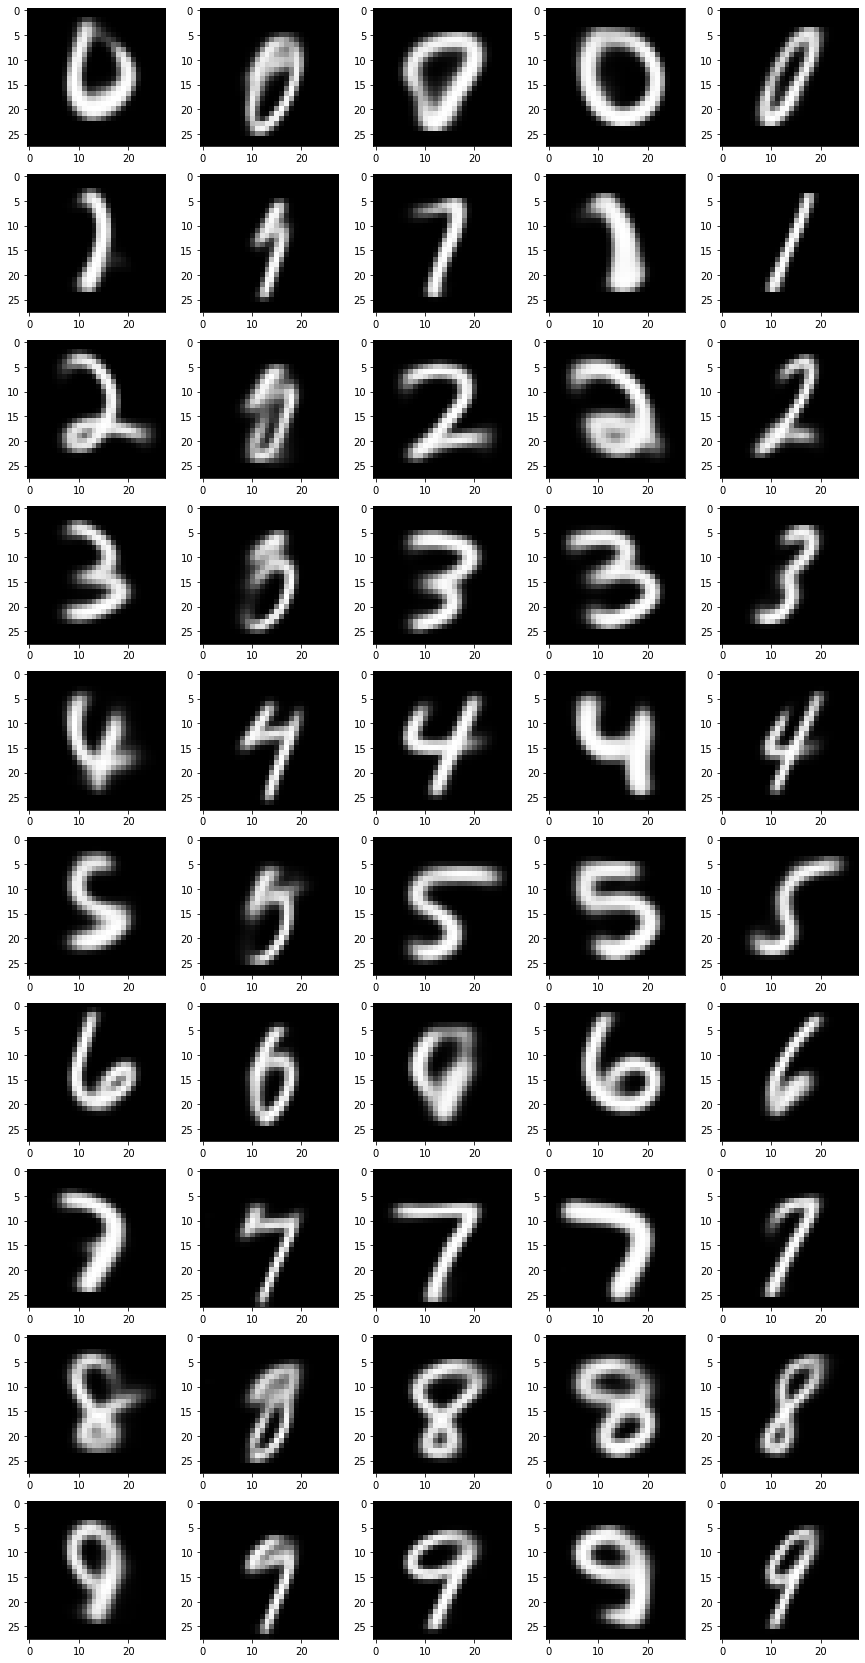

In [97]:
# без поправки на means и stds
z = torch.FloatTensor(np.array([np.random.normal(0, 1, dim_code) for i in range(5)]))

# скормим z декодеру
conditional_vae.eval()
result = []
with torch.no_grad():
  for i in range(10):
    output = conditional_vae.decode(z.to(device), numbers[i].to(device)).cpu().detach()
    result.append(output)

# выведем полученные картинки
plt.figure(figsize=(15, 30))
for i, imgs in enumerate(result):
  for j, img in enumerate(imgs):
    plt.subplot(10, 5, 5*i+j+1)
    plt.imshow(img[0], cmap='gray')

Без поправки means и stds числа генерируются менее похожими, но более различными. Плюс, прослеживается "почерк" (цифры по столбцам похожи)

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

Пространство латентных векторов, размерность: (10000, 32)
Пространство векторов после TSNE, размерность: (10000, 2)


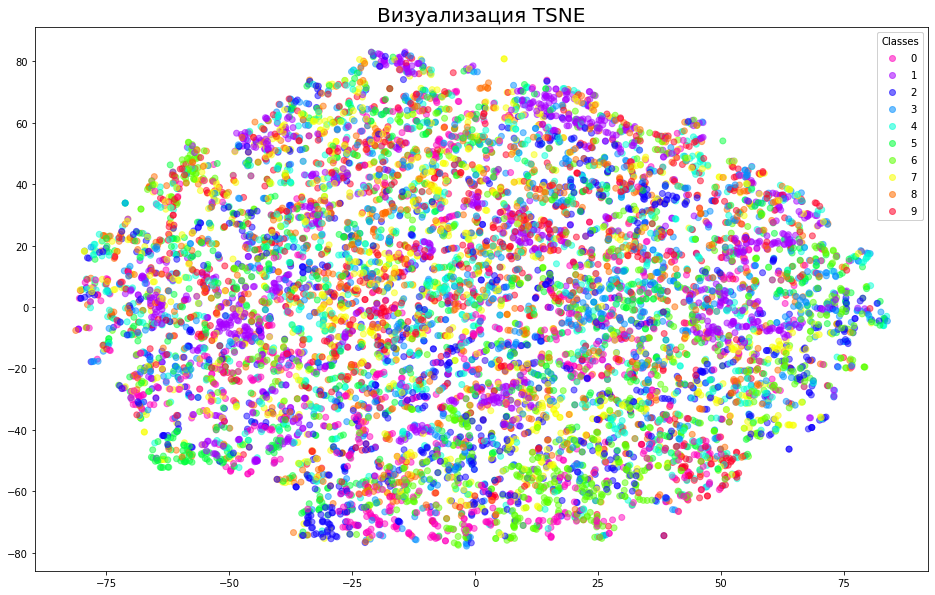

In [99]:
# ваш код получения латентных представлений, применения TSNE и визуализации

# лейблы цифр из val_dataset
labels = []
for data in val_dataset:
  labels.append(data[1])

# получение латентных представлений
conditional_vae.eval()
latent_space = torch.tensor([])
with torch.no_grad():
    for i, batch in enumerate(val_loader):
      latent_mu, _ , _ = conditional_vae(batch[0].to(device), batch[1].to(device))
      latent_mu = latent_mu.cpu().detach()
      if i==0:
        latent_space = latent_mu
      else:
        latent_space = torch.cat((latent_space, latent_mu))   

latent_space = latent_space.numpy()
print(f'Пространство латентных векторов, размерность: {latent_space.shape}')

# применения TSNE 
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
space = tsne.fit_transform(latent_space)
print(f'Пространство векторов после TSNE, размерность: {space.shape}')

# визуализация
fig, ax = plt.subplots(figsize=(16,10))
scatter = ax.scatter(x=space[:,0], y=space[:, 1], c=labels, cmap='gist_rainbow_r', alpha=0.5)
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
plt.title('Визуализация TSNE', fontsize=20);

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

#### Вывод:
Визуализация TSNE для CVAE не похожа на визуализацию для VAE. Это связано с тем, что CVAE тратит свои веса не для того, чтобы запоминать, какая цифра приходит на вход (запоминать закорючки и т.д.). CVAE уже заранее знает, какую цифру надо воспроизвести

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>